In [13]:
%matplotlib inline

from numpy import sqrt, exp, cos, logical_and, where
from clawpack import riemann
from clawpack import pyclaw

def advection(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d linear advection riemann solver 
    """
    import numpy as np
    num_eqn = 1
    num_waves = 1

    # Convenience
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))

    delta = q_r - q_l
    a =  problem_data['a']
    
    # Compute the wave
    # 1-Wave
    wave[0,0,:] = delta 
    s[0,:] = a

    # Compute the left going and right going fluctuations
    for m in range(num_eqn):
        amdq[m,:] = min(a,0) * wave[m,0,:]
        apdq[m,:] = max(a,0) * wave[m,0,:]

    return wave, s, amdq, apdq


def setup(outdir='./_output',  output_style=1):
    
    solver = pyclaw.ClawSolver1D(advection)
    #solver = pyclaw.SharpClawSolver1D()
    solver.rp = riemann.advection_1D_py.advection_1D 
    solver.rp = advection
    
    solver.num_waves = 1
    solver.num_eqn   = 1
    solver.kernel_language = 'Python'
    solver.limiters    = pyclaw.limiters.tvd.MC
    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic
    #solver.order = 2 #1: Godunov, 2: Lax-Wendroff-LeVeque
    
    x = pyclaw.Dimension(0.0, 1.0, 100, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    
    state = pyclaw.State(domain, num_eqn)
    
    a = 0.5  # advection velocity
    state.problem_data['a'] = a
    
    xc = domain.grid.x.centers
    beta = 100
    gamma = 0
    x0 = 0.75
    state.q[0, :] = exp(-beta * (xc-x0)**2) + where(logical_and(xc > 0.1, xc < 0.4),  1, 0)
     
    claw = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.output_style = output_style
    claw.tfinal = 4.0
    claw.num_output_times = 10
    claw.keep_copy = True
    #claw.setplot = setplot

    return claw


def setplot(plotdata):
    """ 
    Plot solution using VisClaw.
    """ 
    plotdata.clearfigures()  # clear any old figures,axes,items data

    plotfigure = plotdata.new_plotfigure(name='q', figno=1)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.ylimits = [-.2,1.0]
    plotaxes.title = 'q'

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 0
    plotitem.plotstyle = '-o'
    plotitem.color = 'b'
    plotitem.kwargs = {'linewidth':2,'markersize':5}
    
    return plotdata

def qtrue(x,t):
    """
    The true solution, for comparison.  
    """
    from numpy import mod, exp, where, logical_and
    beta = 100
    gamma = 0
    x0 = 0.75
    a = claw.solution.state.problem_data['a']  
    xm = x - a*t
    xm = mod(xm, 1.)   # because of periodic boundary conditions
    q = exp(-beta * (xm-x0)**2) + where(logical_and(xm > 0.1, xm < 0.4),  1, 0)
    return q

In [14]:
claw = setup()
claw.run()

from clawpack.visclaw import data
from clawpack.visclaw import frametools
plotdata = data.ClawPlotData()
plotdata.setplot = setplot
claw.plotdata = frametools.call_setplot(setplot,plotdata)

frame = claw.load_frame(10)
f=claw.plot_frame(frame)

2024-03-31 19:54:07,988 INFO CLAW: Solution 0 computed for time t=0.000000
2024-03-31 19:54:07,998 INFO CLAW: Solution 1 computed for time t=0.400000
2024-03-31 19:54:08,007 INFO CLAW: Solution 2 computed for time t=0.800000
2024-03-31 19:54:08,015 INFO CLAW: Solution 3 computed for time t=1.200000
2024-03-31 19:54:08,023 INFO CLAW: Solution 4 computed for time t=1.600000
2024-03-31 19:54:08,032 INFO CLAW: Solution 5 computed for time t=2.000000
2024-03-31 19:54:08,041 INFO CLAW: Solution 6 computed for time t=2.400000
2024-03-31 19:54:08,052 INFO CLAW: Solution 7 computed for time t=2.800000
2024-03-31 19:54:08,059 INFO CLAW: Solution 8 computed for time t=3.200000
2024-03-31 19:54:08,067 INFO CLAW: Solution 9 computed for time t=3.600000
2024-03-31 19:54:08,076 INFO CLAW: Solution 10 computed for time t=4.000000
Executed setplot successfully


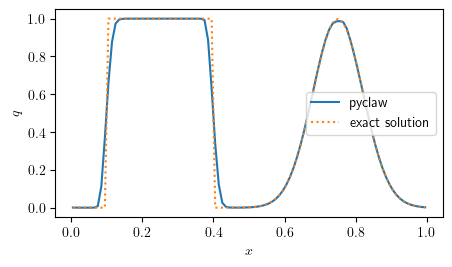

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
indice_plot = 5
frame = claw.frames[indice_plot]
dt = claw.tfinal/claw.num_output_times
t = dt*indice_plot  
x = frame.state.grid.c_centers
x = x[0]
true = qtrue(x,t)
fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]

ax.plot(x, w, label='pyclaw')
ax.plot(x, true, ':',label='exact solution')
ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("frameAdvection5.pdf")

In [18]:
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    fig = plt.figure(figsize=(5,3))
    frame = claw.frames[i]
    w = frame.q[0,:]
    x = frame.state.grid.c_centers
    x = x[0]
    dt = claw.tfinal/claw.num_output_times
    t = dt*i
    true = qtrue(x,t)
    plt.plot(x, w)
    plt.plot(x, true, '--',color = 'r')
    figs.append(fig)
    plt.close(fig)
    

In [19]:
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs)

interactive(children=(IntSlider(value=0, description='frameno', max=10), Output()), _dom_classes=('widget-inte…

In [24]:
def q_true(t):
    import numpy
    # True Solution
    x_true = numpy.linspace(0, 1.0, 1000)
    q_true = qtrue(x_true,t)
    return q_true

def animation():
    import matplotlib.animation
    import numpy
    # compute the solution with the method define above:
    claw = setup()
    claw.keep_copy = True
    claw.run()
    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(0, 1.0, 1000)
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.1, 2))
    axes.set_title("Linear advection equation")
    
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((-0.1,2.1))
        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'ro')
        exact_line, = axes.plot(x_true[0], q_true(0.0)[0], 'k')
        return (computed_line, exact_line)
    
    computed_line, exact_line = init()
    
    def fplot(n):
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [q_true(claw.frames[n].t)])
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=init, repeat=False)



In [26]:
from IPython.display import HTML 
anim = animation()
HTML(anim.to_jshtml())

2024-03-31 19:58:27,895 INFO CLAW: Solution 0 computed for time t=0.000000
2024-03-31 19:58:27,904 INFO CLAW: Solution 1 computed for time t=0.400000
2024-03-31 19:58:27,911 INFO CLAW: Solution 2 computed for time t=0.800000
2024-03-31 19:58:27,920 INFO CLAW: Solution 3 computed for time t=1.200000
2024-03-31 19:58:27,930 INFO CLAW: Solution 4 computed for time t=1.600000
2024-03-31 19:58:27,939 INFO CLAW: Solution 5 computed for time t=2.000000
2024-03-31 19:58:27,947 INFO CLAW: Solution 6 computed for time t=2.400000
2024-03-31 19:58:27,956 INFO CLAW: Solution 7 computed for time t=2.800000
2024-03-31 19:58:27,964 INFO CLAW: Solution 8 computed for time t=3.200000
2024-03-31 19:58:27,975 INFO CLAW: Solution 9 computed for time t=3.600000
2024-03-31 19:58:27,986 INFO CLAW: Solution 10 computed for time t=4.000000
2024-03-31 19:58:28,736 INFO CLAW: Animation.save using <class 'matplotlib.animation.HTMLWriter'>
